# <u>Diagnosis of Diabetes using weight adjusted voting of an ensemble of classifiers<u>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

In [6]:
dataFrame = pd.read_table('pima-indians-diabetes.data', sep = ',', header = None)
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
0    768 non-null int64
1    768 non-null int64
2    768 non-null int64
3    768 non-null int64
4    768 non-null int64
5    768 non-null float64
6    768 non-null float64
7    768 non-null int64
8    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 60.0 KB


In [7]:
dataFrame.columns = ['no_times_pregnant','plasma_glucose_conc','diastolic_bp',\
                    'triceps_sf_thickness','insulin','bmi',\
                     'diabetes_pedigree_function','age','isDiabetic']

In [9]:
dataFrame.head()

,no_times_pregnant,plasma_glucose_conc,diastolic_bp,triceps_sf_thickness,insulin,bmi,diabetes_pedigree_function,age,isDiabetic
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [11]:
dataFrame.describe()

,no_times_pregnant,plasma_glucose_conc,diastolic_bp,triceps_sf_thickness,insulin,bmi,diabetes_pedigree_function,age,isDiabetic
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [12]:
pandas_profiling.ProfileReport(dataFrame)

Number of variables,9
Number of observations,768
Total Missing (%),0.0%
Total size in memory,60.0 KiB
Average record size in memory,80.0 B
Numeric,9
Categorical,0
Date,0
Text (Unique),0
Rejected,0
Distinct count,52


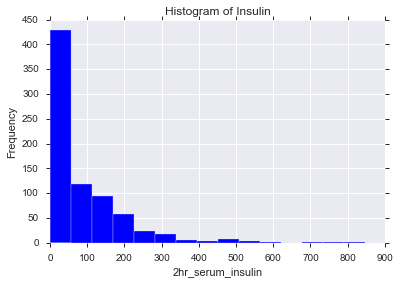

In [21]:
% matplotlib inline
dataFrame.insulin.hist(bins = 15)
plt.title('Histogram of Insulin')
plt.xlabel('2hr_serum_insulin')
plt.ylabel('Frequency')

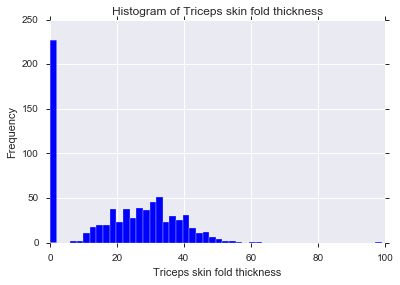

In [23]:
dataFrame.triceps_sf_thickness.hist(bins = 50)
plt.title('Histogram of Triceps skin fold thickness')
plt.xlabel('Triceps skin fold thickness')
plt.ylabel('Frequency')

## The summary of all the cloumns with missing values 
   |Columns                       |# of Missing values | % of missing values|   
   |------------------------------|:------------------:|:------------------:|      
   | 2-Hour serum insulin         | 374  |   ~ 50%   |                                   
   | Triceps skin fold thickness  | 227  |  30%    |                                
   | ~~Number of times pregnant~~   | 111|   15%   |                             
   | Diastolic blood pressure     | 35   |    4.6%  |                         
   | Body mass index              | 11   |   1.4%   |                       
   | Plasma glucose concentration | 5    |   -   |
   | Diabetes pedigree function   | NONE |    -  |
   | Age (years)                  | NONE |    -  |
   

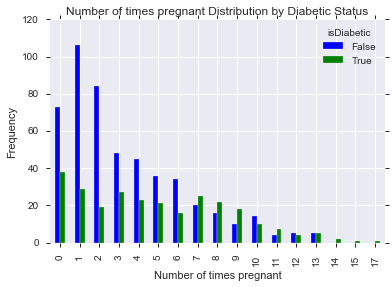

In [34]:
pd.crosstab(dataFrame.no_times_pregnant, dataFrame.isDiabetic.astype(bool)).plot(kind='bar')
plt.title('Number of times pregnant Distribution by Diabetic Status')
plt.xlabel('Number of times pregnant')
plt.ylabel('Frequency')

In [35]:
# removing the rows from the data set where some values are 0's that do not biologically make sense
dataFrame = dataFrame[dataFrame['diastolic_bp'] !=0]
dataFrame = dataFrame[dataFrame['bmi'] !=0]


In [54]:
diabetic_patients = dataFrame[dataFrame['isDiabetic']==1]
non_diabetic_patients = dataFrame[dataFrame['isDiabetic']==0]

# sampling randomly shuffles the dataframe
diabetic_patients = diabetic_patients.sample(frac=1, random_state= 3)
non_diabetic_patients = non_diabetic_patients.sample(frac=1, random_state= 3)

    
dp1,dp2,dp3 = np.array_split(diabetic_patients,3)
ndp1,ndp2,ndp3 = np.array_split(non_diabetic_patients,3)

frames1 = [dp1,ndp1]
frames2 = [dp2,ndp2]
frames3 = [dp3,ndp3]

dataset1 = pd.concat(frames1)
dataset2 = pd.concat(frames2)
dataset3 = pd.concat(frames3)

del dp1,dp2,dp3,ndp1,ndp2,ndp3,diabetic_patients,non_diabetic_patients, frames1,frames2,frames3 

print(dataset1.shape)
print(dataset2.shape)
print(dataset3.shape)

(244, 9)
(243, 9)
(242, 9)


### Split the data set into training set and test set

In [ ]:
features = ['no_times_pregnant','plasma_glucose_conc','diastolic_bp',\
                    'triceps_sf_thickness','insulin','bmi',\
                     'diabetes_pedigree_function','age']
output = ['isDiabetic']

X_train = dataset1[features]
y_train = dataset1[output]

X_test = dataset2[features]
y_test = dataset2[output]

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)